# Using Existing Accuracy Reference Points

You maybe fortunate enough to have some existing reference points which you can use for your accuracy assessment. If this is the case then you simply need to populate those points with your classification information. 

## Running Notebook

The notebook has been run and saved with the outputs so you can see what the outputs should be and so the notebook and be browsed online without having to run the notebook for it to make sense. 

If you are running the notebook for yourself it is recommended that you clear the existing outputs which can be done by running one of the following options depending on what system you are using:

**Jupyter-lab**:

> \> _Edit_ \> _'Clear All Outputs'_

**Jupyter-notebook**:

> \> _Cell_ \> _'All Outputs'_ \> _Clear_


# 1. Import Modules

In [1]:
import os

# Import the geopandas module - used for visualisation.
import geopandas

# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Import the rsgislib classification module
import rsgislib.classification

# Import rsgislib vectorutils module 
import rsgislib.vectorutils

# Import the rsgislib tools plotting module for visualisation
import rsgislib.tools.plotting

# Import the rsgislib tools utils module
import rsgislib.tools.utils

# 2. Define Input Files

We will use the Extra Trees reflectance classification as the base classification.

In [2]:
cls_img = os.path.join("cls_refl_results", "cls_et_refl.kea")

# Input Sentinel-2 image file with 20 m resolution pixels - just needed for visualisation
input_img = "../data/sen2_20180629_t30uvd_orb037_osgb_stdsref_20m.tif"


vec_file = "../data/cls_data/cls_acc_assessment_pts_ref.geojson"
vec_lyr = "cls_acc_assessment_pts_ref"

# 3. Create Output Directories

In [3]:
out_pts_dir = "acc_pts"
if not os.path.exists(out_pts_dir):
    os.mkdir(out_pts_dir)
    
out_stats_dir = "acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)

# 4. Copy Existing Points File

To avoid overwriting and editting the input file provided we will first copy it into our output directory.


In [4]:
vec_refpts_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref.geojson")
vec_refpts_lyr = "cls_acc_assessment_pts_ref"

rsgislib.vectorutils.vector_translate(vec_file, vec_lyr, vec_refpts_file, vec_refpts_lyr, out_format="GeoJSON", del_exist_vec=True)

Deleting: acc_pts/cls_acc_assessment_pts_ref.geojson


101it [00:00, 11691.04it/s]                                                                                                                                        


# 5. Visualise Reference Points

Image Data Size: 3295 x 2880


/Users/pfb/miniconda3/envs/rsgislib_py_dev/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


<Axes: >

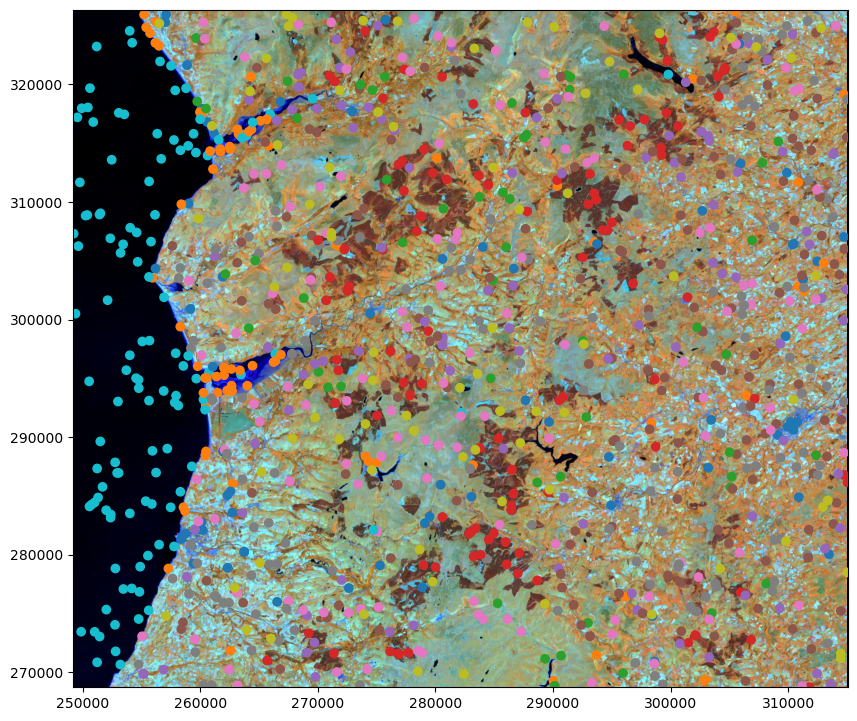

In [5]:
# Read image data
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[8, 9, 3]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Read points to geopandas dataframe
points_gdf = geopandas.read_file(vec_refpts_file)
# Plot the plots over the image data
# Note. Points are randomly coloured by reference class
points_gdf.plot(ax=ax, column='ref_pts')

# 5.1 Look at attribute table

As you can see below the attribute table just has a single column `ref_pts` with the reference class for each point.

In [6]:
points_gdf

,ref_pts,geometry
0,Bare_Rock_Sand,POINT (293492.332 306597.255)
1,Artificial_Surfaces,POINT (312462.332 304967.255)
2,Bare_Rock_Sand,POINT (306412.332 293567.255)
3,Artificial_Surfaces,POINT (259012.332 309877.255)
4,Artificial_Surfaces,POINT (305842.332 323467.255)
...,...,...
995,Water,POINT (250902.332 316807.255)
996,Water,POINT (257912.332 297147.255)
997,Water,POINT (249762.332 311677.255)
998,Water,POINT (253712.332 295707.255)


# 6. Populate Reference Points

Using the reference points we will use the `rsgislib.classification.pop_class_info_accuracy_pts` function to populate the classification from `cls_et_refl.kea` on to these points:


In [7]:
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=cls_img,
    vec_file=vec_refpts_file,
    vec_lyr=vec_refpts_lyr,
    rat_class_col="class_names",
    vec_class_col="et_rl_cls",
    vec_ref_col=None,
    vec_process_col=None,
)

# 6.1 What has changed in the attribute table?

In [8]:
points_gdf = geopandas.read_file(vec_refpts_file)
points_gdf

,ref_pts,et_rl_cls,geometry
0,Bare_Rock_Sand,Artificial_Surfaces,POINT (293492.332 306597.255)
1,Artificial_Surfaces,Grass_Short,POINT (312462.332 304967.255)
2,Bare_Rock_Sand,Artificial_Surfaces,POINT (306412.332 293567.255)
3,Artificial_Surfaces,Scrub,POINT (259012.332 309877.255)
4,Artificial_Surfaces,Artificial_Surfaces,POINT (305842.332 323467.255)
...,...,...,...
995,Water,Water,POINT (250902.332 316807.255)
996,Water,Water,POINT (257912.332 297147.255)
997,Water,Water,POINT (249762.332 311677.255)
998,Water,Water,POINT (253712.332 295707.255)


There is now as extra column `et_rl_cls` and by comparing `ref_pts` to that column we can assess the accuracy of our classification.

# 8. Filter Valid Points

Some classifiers can produce no data regions and if those intersect with reference points then an error will occur when calculating the accuracy statistics so we need to remove those which we will do using geopandas. For points where there is no class (i.e., no data) in the input classification then the value `"NA"` is outputted into the attribute table and it is rows with an `"NA"` value that we want to remove.


In [9]:
vec_refpts_vld_file = os.path.join(out_pts_dir, "cls_acc_assessment_pts_ref_vld.geojson")
vec_refpts_vld_lyr = "cls_acc_assessment_pts_ref_vld"
points_gdf = points_gdf.drop(points_gdf[points_gdf["et_rl_cls"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")
points_gdf


,ref_pts,et_rl_cls,geometry
0,Bare_Rock_Sand,Artificial_Surfaces,POINT (293492.332 306597.255)
1,Artificial_Surfaces,Grass_Short,POINT (312462.332 304967.255)
2,Bare_Rock_Sand,Artificial_Surfaces,POINT (306412.332 293567.255)
3,Artificial_Surfaces,Scrub,POINT (259012.332 309877.255)
4,Artificial_Surfaces,Artificial_Surfaces,POINT (305842.332 323467.255)
...,...,...,...
995,Water,Water,POINT (250902.332 316807.255)
996,Water,Water,POINT (257912.332 297147.255)
997,Water,Water,POINT (249762.332 311677.255)
998,Water,Water,POINT (253712.332 295707.255)


Your classification result maybe different to mine and therefore no rows might have been removed but for my result 1 row was removed reducing the number of reference samples to 999.

# 7. Calculate Classification Accuracy

RSGISLib provides a couple of functions for this and we will use the `calc_acc_metrics_vecsamples` function. 


In [10]:
# Import the calc_acc_metrics_vecsamples function from the 
# rsgislib.classification.classaccuracymetrics module.
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples_img


out_json_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.json")
out_csv_file = os.path.join(out_stats_dir, "cls_rf_refl_acc_info.csv")

calc_acc_metrics_vecsamples_img(
    vec_file=vec_refpts_vld_file,
    vec_lyr=vec_refpts_vld_lyr,
    ref_col="ref_pts",
    cls_col="et_rl_cls",
    cls_img=cls_img,
    img_cls_name_col="class_names",
    img_hist_col="Histogram",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file,
)


{'Artificial_Surfaces': {'precision': 0.6567164179104478,
  'recall': 0.6666666666666666,
  'f1-score': 0.6616541353383459,
  'support': 66},
 'Bare_Rock_Sand': {'precision': 0.49514563106796117,
  'recall': 0.6891891891891891,
  'f1-score': 0.5762711864406779,
  'support': 74},
 'Bracken': {'precision': 0.3826086956521739,
  'recall': 0.8461538461538461,
  'f1-score': 0.5269461077844311,
  'support': 52},
 'Conifer_Forest': {'precision': 1.0,
  'recall': 0.8557692307692307,
  'f1-score': 0.9222797927461139,
  'support': 104},
 'Deciduous_Forest': {'precision': 0.7435897435897436,
  'recall': 0.8787878787878788,
  'f1-score': 0.8055555555555556,
  'support': 99},
 'Grass_Long': {'precision': 0.8,
  'recall': 0.36879432624113473,
  'f1-score': 0.5048543689320388,
  'support': 141},
 'Grass_Short': {'precision': 0.6351351351351351,
  'recall': 0.7642276422764228,
  'f1-score': 0.6937269372693727,
  'support': 123},
 'NonPhoto_Veg': {'precision': 0.9468085106382979,
  'recall': 0.61805555

This function will have outputted two files:

 * A CSV file with the accuracy statistics which is useful for opening in a spreadsheet application 
 * A JSON file with the same accuracy statistics but in a format which can be more easily read and used within a script.


## 7.1 Reading the JSON file

Let's now have a look at the JSON file which has been outputted. One thing you will notice is this isn't the most user friendly way of presenting this data, hence why the function also outputs a CSV. However, it easy to read out particular values in python, as shown below.

In [11]:
import pprint
cls_acc_stats_dict = rsgislib.tools.utils.read_json_to_dict(out_json_file)
pprint.pprint(cls_acc_stats_dict)

{'Artificial_Surfaces': {'f1-score': 0.6616541353383459,
                         'precision': 0.6567164179104478,
                         'recall': 0.6666666666666666,
                         'support': 66},
 'Bare_Rock_Sand': {'f1-score': 0.5762711864406779,
                    'precision': 0.49514563106796117,
                    'recall': 0.6891891891891891,
                    'support': 74},
 'Bracken': {'f1-score': 0.5269461077844311,
             'precision': 0.3826086956521739,
             'recall': 0.8461538461538461,
             'support': 52},
 'Conifer_Forest': {'f1-score': 0.9222797927461139,
                    'precision': 1.0,
                    'recall': 0.8557692307692307,
                    'support': 104},
 'Deciduous_Forest': {'f1-score': 0.8055555555555556,
                      'precision': 0.7435897435897436,
                      'recall': 0.8787878787878788,
                      'support': 99},
 'Grass_Long': {'f1-score': 0.5048543689320388,
          

In [12]:
print("Overall Accuracy: {}".format(cls_acc_stats_dict["accuracy"]))
print("Macro F1 Score: {}".format(cls_acc_stats_dict["macro avg"]["f1-score"]))
print("Area Weighted F1 Score: {}".format(cls_acc_stats_dict["weighted area avg"]["f1-score"]))

Overall Accuracy: 0.7117117117117117
Macro F1 Score: 0.7038624007683294
Area Weighted F1 Score: 0.7117756280848822


One thing we can note from the overall accuracy figure we have calculuted here is that it is much lower than what was estimated using the classification sample data, which as previously discussed, is note a good example of classification sample (training, testing and validation) data. The next question is how the accuracies compare for all the classifiers we have tried.